In [ ]:
# Import necessary libraries
import pandas as pd

# Load the dataset (file path based on upload)
file_path = '/content/fraud_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

# Check for missing values and basic data info
print(data.info())

# Describe the dataset to check numerical feature distribution
print(data.describe())

print(data['Label'].value_counts())

   Transaction Amount  Transaction Frequency Recipient Verification Status  \
0           36.907066                      6                      verified   
1           37.879209                      0                      verified   
2         1250.985077                      2           recently_registered   
3         2972.505568                      3           recently_registered   
4          501.334960                      2                      verified   

   Recipient Blacklist Status  Device Fingerprinting  VPN or Proxy Usage  \
0                           0                      0                   0   
1                           1                      0                   1   
2                           1                      0                   0   
3                           0                      0                   0   
4                           0                      0                   0   

  Geo-Location Flags  Behavioral Biometrics  Time Since Last Transaction  

In [ ]:
# Dynamically identify numerical and categorical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.drop('Label', errors='ignore')
categorical_cols = data.select_dtypes(include=['object']).columns

from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler from sklearn.preprocessing
# Normalize numerical features
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Encode categorical features using one-hot encoding
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Verify preprocessing
print("Preprocessed data:")
print(data.head())

# Step 2: Split Data

# Separate features (X) and target (y)
X = data.drop('Label', axis=1)
y = data['Label']

from sklearn.model_selection import train_test_split
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the split
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Class distribution in training set:\n{y_train.value_counts()}")
print(f"Class distribution in testing set:\n{y_test.value_counts()}")


Preprocessed data:
   Transaction Amount  Transaction Frequency  Recipient Blacklist Status  \
0            0.007772               0.461538                         0.0   
1            0.007977               0.000000                         1.0   
2            0.263483               0.153846                         1.0   
3            0.626072               0.230769                         0.0   
4            0.105591               0.153846                         0.0   

   Device Fingerprinting  VPN or Proxy Usage  Behavioral Biometrics  \
0                    0.0                 0.0               0.119084   
1                    0.0                 1.0               0.189293   
2                    0.0                 0.0               0.140006   
3                    0.0                 0.0               0.598354   
4                    0.0                 0.0               0.149103   

   Time Since Last Transaction  Social Trust Score  Account Age  \
0                     0.794263

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam

# Generator Model
def build_generator(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim))  # First Dense layer
    model.add(LeakyReLU(0.2))  # Adding LeakyReLU activation
    model.add(Dense(output_dim, activation='sigmoid'))  # Change activation to 'sigmoid'
    return model

# Discriminator Model
def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim))  # First Dense layer
    model.add(LeakyReLU(0.2))  # Adding LeakyReLU activation
    model.add(Dense(1, activation='sigmoid'))  # Output layer with 'sigmoid' activation for binary classification
    return model

# Create the GAN (Generative Adversarial Network)
def build_gan(generator, discriminator):
    # The discriminator should be non-trainable when we train the GAN (we only train the generator in this phase)
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))  # Input to the generator
    x = generator(gan_input)  # Generator output
    gan_output = discriminator(x)  # Pass generator output to the discriminator
    gan = tf.keras.models.Model(gan_input, gan_output)
    return gan

# Dimensions
latent_dim = 100  # Dimensionality of the random noise input for the generator
input_dim = X_train.shape[1]  # Number of features in the transaction data (input size)

# Build the generator and discriminator
generator = build_generator(latent_dim, input_dim)
discriminator = build_discriminator(input_dim)

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

# Build the GAN (including the generator and discriminator)
gan = build_gan(generator, discriminator)

# Compile the GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import numpy as np

# Set the number of epochs and batch size
epochs = 1000
batch_size = 64
half_batch = batch_size // 2

# Function to train the GAN
def train_gan(generator, discriminator, gan, X_train, epochs, batch_size, latent_dim):
    # Training loop
    for epoch in range(epochs):
        # ---- Train the Discriminator ----
        # Select a random batch of real data
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_data = X_train.iloc[idx].values.astype(np.float32)  # Convert to float32 if necessary

        # Generate a batch of synthetic data from the generator
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        synthetic_data = generator.predict(noise)

        # Train the discriminator (real = 1, fake = 0)
        real_labels = np.random.uniform(0.9, 1.0, (half_batch, 1)).astype(np.float32)  # Smoothed labels for real data
        fake_labels = np.random.uniform(0.0, 0.1, (half_batch, 1)).astype(np.float32)  # Smoothed labels for fake data

        # Add noise to real data for stability
        real_data += np.random.normal(0, 0.01, real_data.shape)  # Small Gaussian noise

        # Train the discriminator on real and fake data
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(synthetic_data, fake_labels)

        # Average discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---- Train the Generator ----
        # Generate noise and train the generator to fool the discriminator (label = 1 for "real")
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  # Generator tries to make discriminator think "real"

        # Print the progress
        #if epoch % 10 == 0:  # Adjust frequency of logging
            #print(f"{epoch} [D loss: {d_loss[0]:.4f} | D accuracy: {d_loss[1]:.4f}] [G loss: {g_loss:.4f}]")

        # ---- Optional: Inspect Generated Data ----
        if epoch % 50 == 0:  # Every 50 epochs, check synthetic data range
            sample_noise = np.random.normal(0, 1, (5, latent_dim))
            generated_samples = generator.predict(sample_noise)
            print("Generated sample range:", generated_samples.min(), generated_samples.max())

# Call the train function
train_gan(generator, discriminator, gan, X_train, epochs, batch_size, latent_dim)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Generated sample range: 0.09687605 0.8853972
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [ ]:
# Generate synthetic data after training
num_samples = X_train.shape[0]  # Generate as many samples as in the training set
noise = np.random.normal(0, 1, (num_samples, latent_dim))
synthetic_data = generator.predict(noise)


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


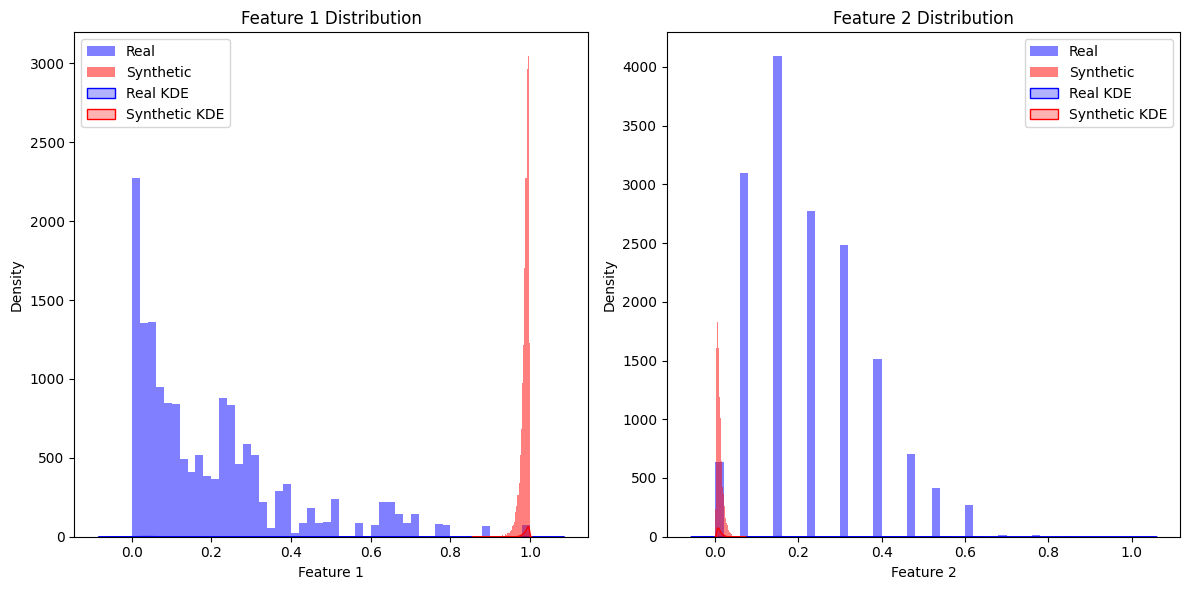

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure synthetic data is generated
num_samples = X_train.shape[0]  # Generate as many samples as the real training set
noise = np.random.normal(0, 1, (num_samples, latent_dim))
synthetic_data = generator.predict(noise)

# Select a few features for visualization
num_features = 2  # Number of features to visualize
real_data_subset = X_train.iloc[:, :num_features].values  # Select features from real data
synthetic_data_subset = synthetic_data[:, :num_features]  # Select same features from synthetic data

# Plot histograms and KDE for real vs synthetic data
plt.figure(figsize=(12, 6))

for i in range(num_features):  # Loop over selected features
    plt.subplot(1, num_features, i + 1)

    # Histogram
    plt.hist(real_data_subset[:, i], bins=50, alpha=0.5, label='Real', color='blue')
    plt.hist(synthetic_data_subset[:, i], bins=50, alpha=0.5, label='Synthetic', color='red')

    # KDE Plot
    sns.kdeplot(real_data_subset[:, i], color='blue', label='Real KDE', fill=True, alpha=0.3)
    sns.kdeplot(synthetic_data_subset[:, i], color='red', label='Synthetic KDE', fill=True, alpha=0.3)

    plt.title(f"Feature {i + 1} Distribution")
    plt.xlabel(f"Feature {i + 1}")
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


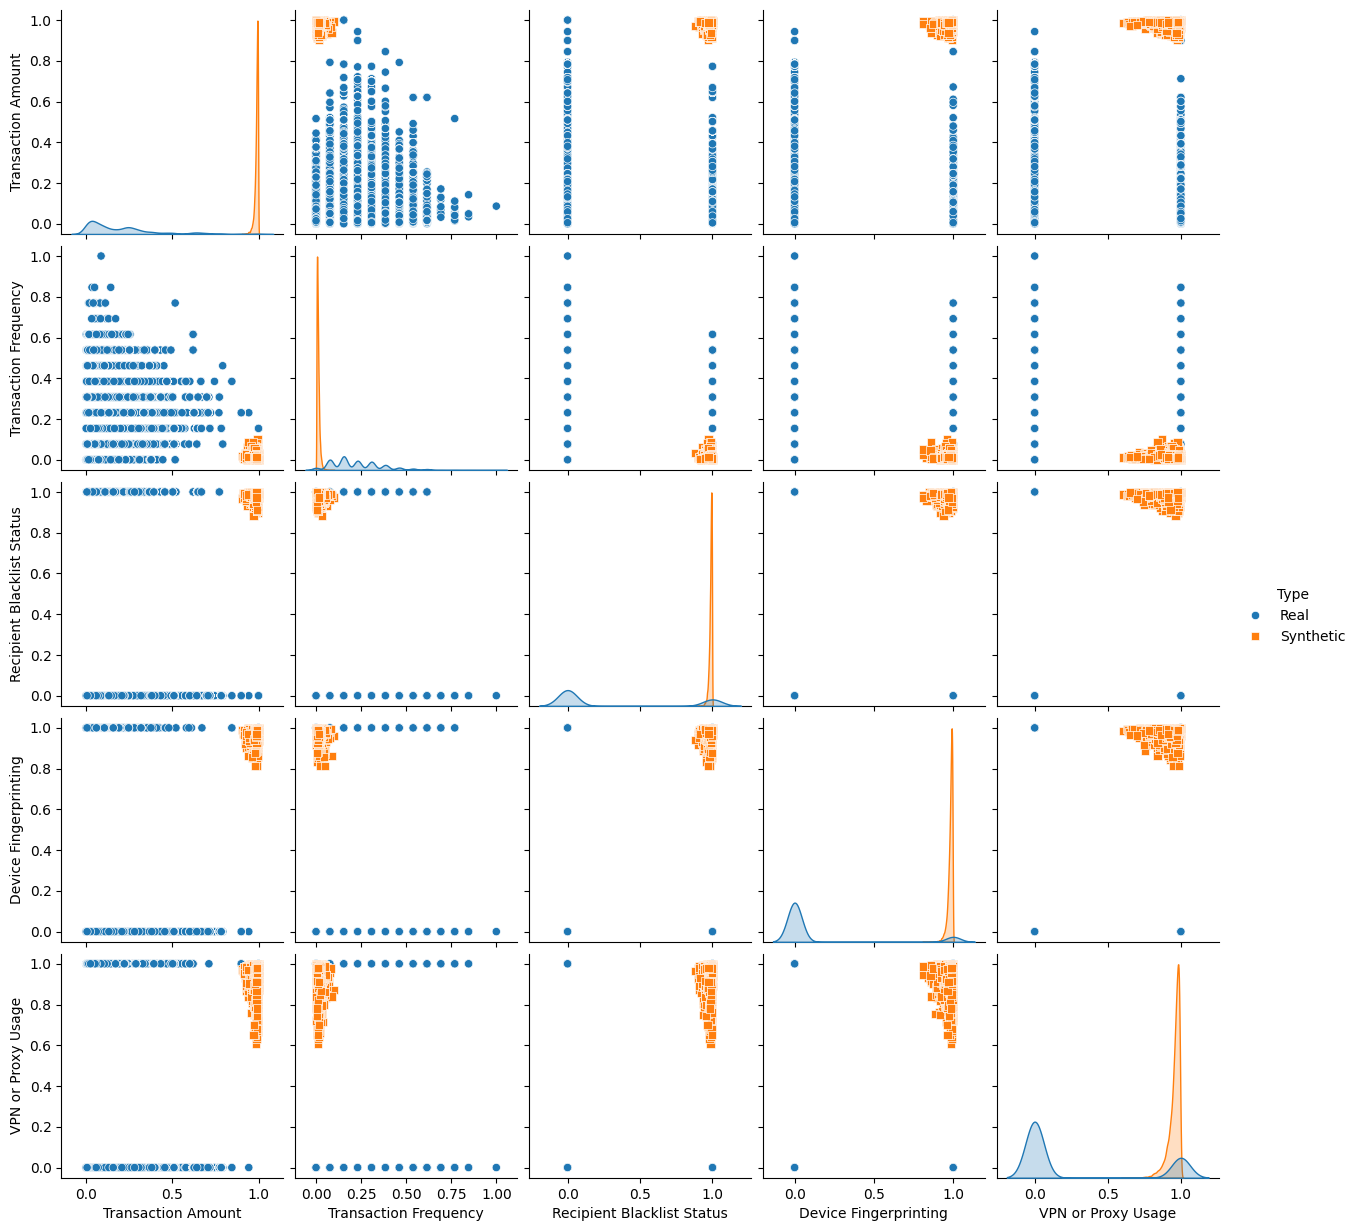

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Number of features to use for the pairplot
num_features = 5

# Generate synthetic data for the selected features
num_samples = X_train.shape[0]  # Number of samples to generate
noise = np.random.normal(0, 1, (num_samples, latent_dim))  # Random noise
synthetic_data = generator.predict(noise)  # Synthetic data generated by the model

# Select the first 5 features from both real and synthetic data
real_data_subset = X_train.iloc[:, :num_features].copy()  # Select the first 5 features from real data
synthetic_data_subset = synthetic_data[:, :num_features]  # Select the first 5 features from synthetic data

# Convert the data to DataFrame
real_data_df = pd.DataFrame(real_data_subset, columns=X_train.columns[:num_features])  # Convert real data to DataFrame
synthetic_data_df = pd.DataFrame(synthetic_data_subset, columns=X_train.columns[:num_features])  # Convert synthetic data to DataFrame

# Add a "Type" column to differentiate real and synthetic data
real_data_df['Type'] = 'Real'
synthetic_data_df['Type'] = 'Synthetic'

# Concatenate real and synthetic data for visualization
combined_data = pd.concat([real_data_df, synthetic_data_df], ignore_index=True)

# Create a pairplot to visualize relationships across the selected features
sns.pairplot(combined_data, hue='Type', diag_kind='kde', markers=["o", "s"])
plt.show()


In [ ]:
# Calculate mean and variance of real vs synthetic data
real_mean = np.mean(X_train, axis=0)  # Use X_train for real data
real_variance = np.var(X_train, axis=0)

synthetic_mean = np.mean(synthetic_data, axis=0)
synthetic_variance = np.var(synthetic_data, axis=0)

print("Real Data - Mean:", real_mean)
print("Real Data - Variance:", real_variance)

print("Synthetic Data - Mean:", synthetic_mean)
print("Synthetic Data - Variance:", synthetic_variance)

# Calculate mean and variance differences
mean_diff = np.abs(real_mean - synthetic_mean)
variance_diff = np.abs(real_variance - synthetic_variance)

print("Mean Difference:", mean_diff)
print("Variance Difference:", variance_diff)



Real Data - Mean: Transaction Amount                          0.198380
Transaction Frequency                       0.224260
Recipient Blacklist Status                  0.290875
Device Fingerprinting                       0.112125
VPN or Proxy Usage                          0.262437
Behavioral Biometrics                       0.277655
Time Since Last Transaction                 0.502275
Social Trust Score                          0.504688
Account Age                                 0.487326
High-Risk Transaction Times                 0.194062
Past Fraudulent Behavior Flags              0.287125
Location-Inconsistent Transactions          0.132875
Normalized Transaction Amount               0.389769
Transaction Context Anomalies               0.211830
Fraud Complaints Count                      0.095588
Merchant Category Mismatch                  0.107938
User Daily Limit Exceeded                   0.145250
Recent High-Value Transaction Flags         0.174000
Recipient Verification Statu

In [ ]:
import numpy as np

# Set the number of synthetic data points you want to generate
num_synthetic_samples = 1000  # Adjust based on your needs

# Generate random noise (latent vectors) for the generator
latent_dim = 100  # Latent dimension of the noise vector (same as used in training)
noise = np.random.normal(0, 1, (num_synthetic_samples, latent_dim))  # Latent vectors

# Generate synthetic data from the generator
synthetic_data = generator.predict(noise)

# Ensure the generated data has the same shape and type as the real data
synthetic_data = synthetic_data.astype(np.float32)


# Check the shape of the synthetic data
print(f"Synthetic Data Shape: {synthetic_data.shape}")


NameError: name 'generator' is not defined

In [ ]:
# Assuming the real data has a class label column for fraud (0: non-fraud, 1: fraud)
# Get the class distribution from the real data
fraud_ratio = np.mean(y_train)  # Calculate the proportion of fraudulent data

# Determine the number of fraudulent and non-fraudulent synthetic samples
num_fraud_samples = int(fraud_ratio * num_synthetic_samples)
num_non_fraud_samples = num_synthetic_samples - num_fraud_samples

# Create the labels for synthetic data (0 for non-fraud, 1 for fraud)
synthetic_labels = np.zeros((num_synthetic_samples, 1))

# Assign labels to synthetic data (fraud = 1, non-fraud = 0)
synthetic_labels[:num_fraud_samples] = 1  # First 'num_fraud_samples' are fraudulent


In [ ]:
# Convert y_train to a NumPy array and reshape it to be a 2D array
y_train = y_train.values.reshape(-1, 1)

# Combine real data with synthetic data
X_train_augmented = np.concatenate((X_train, synthetic_data), axis=0)
y_train_augmented = np.concatenate((y_train, synthetic_labels), axis=0)

# Check the shape of the augmented dataset
print(f"Augmented Data Shape: {X_train_augmented.shape}")
print(f"Augmented Labels Shape: {y_train_augmented.shape}")




Augmented Data Shape: (17000, 22)
Augmented Labels Shape: (17000, 1)


In [ ]:
# Assuming X_train_augmented and y_train_augmented are already defined
X = X_train_augmented  # Features (input data)
y = y_train_augmented  # Labels (target variable)

# Check the shape of the features and labels
print(f"Features Shape: {X.shape}")
print(f"Labels Shape: {y.shape}")


Features Shape: (17000, 22)
Labels Shape: (17000, 1)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the augmented dataset into training (80%) and validation (20%) sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check the shapes of the split datasets

print(f"Training Features Shape: {X_train_split.shape}")
print(f"Validation Features Shape: {X_val_split.shape}")
print(f"Training Labels Shape: {y_train_split.shape}")
print(f"Validation Labels Shape: {y_val_split.shape}")


Training Features Shape: (13600, 22)
Validation Features Shape: (3400, 22)
Training Labels Shape: (13600, 1)
Validation Labels Shape: (3400, 1)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train_split, y_train_split)

# Make predictions on the validation set
y_pred = rf_classifier.predict(X_val_split)

# Calculate accuracy
accuracy = accuracy_score(y_val_split, y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Classifier Accuracy: 97.12%


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],   # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]    # Minimum samples required to split a node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           n_jobs=-1,  # Use all available CPUs
                           verbose=2)

# Fit the grid search on the training data
grid_search.fit(X_train_split, y_train_split)

# Get the best parameters and the best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score: {:.2f}%".format(grid_search.best_score_ * 100))

# Use the best model from the grid search
best_rf_classifier = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best = best_rf_classifier.predict(X_val_split)

# Calculate accuracy with the best model
accuracy_best = accuracy_score(y_val_split, y_pred_best)
print(f"Optimized Random Forest Classifier Accuracy: {accuracy_best * 100:.2f}%")


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-validation Score: 97.26%
Optimized Random Forest Classifier Accuracy: 97.09%


Accuracy: 97.09%
Precision: 0.97
Recall: 0.97
F1-Score: 0.97
AUC-ROC: 1.00


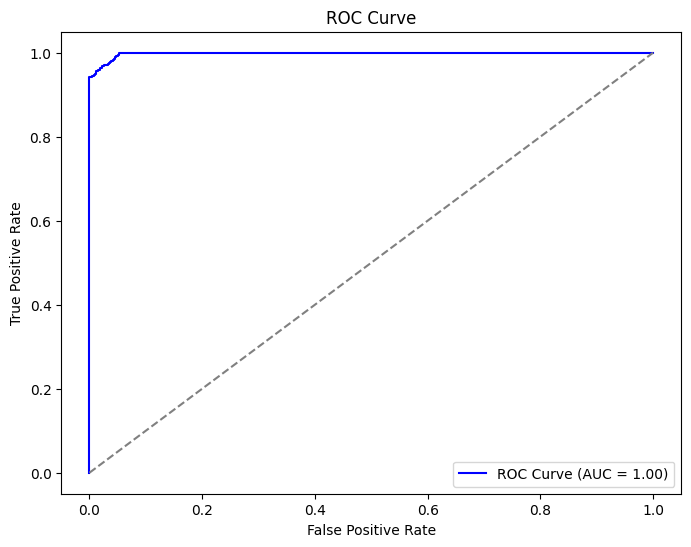

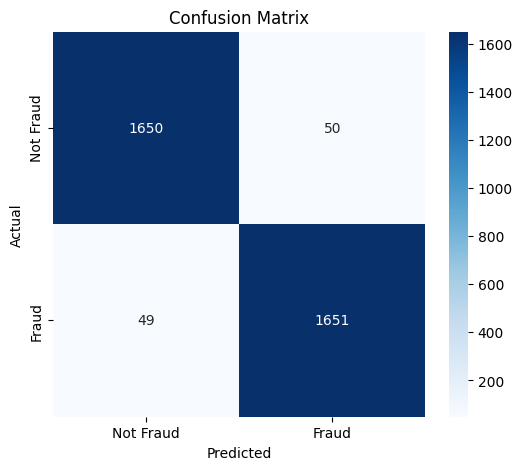

Model saved as 'best_rf_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions using the best model from GridSearchCV
y_pred_best = best_rf_classifier.predict(X_val_split)

# Calculate Accuracy
accuracy = accuracy_score(y_val_split, y_pred_best)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate Precision
precision = precision_score(y_val_split, y_pred_best)
print(f"Precision: {precision:.2f}")

# Calculate Recall
recall = recall_score(y_val_split, y_pred_best)
print(f"Recall: {recall:.2f}")

# Calculate F1-Score
f1 = f1_score(y_val_split, y_pred_best)
print(f"F1-Score: {f1:.2f}")

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_val_split, best_rf_classifier.predict_proba(X_val_split)[:, 1])
print(f"AUC-ROC: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val_split, best_rf_classifier.predict_proba(X_val_split)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val_split, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

import pickle

# Save the best Random Forest model
with open('best_rf_model.pkl', 'wb') as file:
    pickle.dump(best_rf_classifier, file)

print("Model saved as 'best_rf_model.pkl'")


from google.colab import files
files.download('best_rf_model.pkl')
